# Recurrent Neural Networks (RNN)

&copy; 李浩东 3190104890@zju.edu.cn

- Sequence Models
- Text Preprocessing
- Language Models and the Dataset
- Recurrent Neural Networks


$$
x_{t} \sim P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right)
$$

- Music, speech, text, and videos are all sequential in nature. If we were to permute them they would make little sense. The headline dog bites man is much less surprising than man bites dog, even though the words are identical.

- In order to achieve this, we could use a regression model.

$$
x_{t} \sim P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right) \sim P\left(x_{t} \mid x_{t-1},  x_{t-2},\ldots, x_{t-\tau}\right)
$$

- Such models will be called autoregressive models, as they quite literally perform regression on themselves.

- The second strategy, shown in the figure below, is to keep some summary $h_t$ of the past observations, and at the same time update $h_t$ in addition to the prediction $\hat{x}_{t}$. This leads to models that estimate ${x}_{t}$ with $\hat{x}_{t}=P\left(x_{t} \mid h_{t}\right)$ and moreover updates of the form $h_{t}=g\left(h_{t-1}, x_{t-1}\right)$. Since $h_t$ is never observed, these models are also called latent autoregressive models.

![sequence-model.svg](./images/8/sequence-model.svg)


- Both cases raise the obvious question of how to generate training data. One typically uses historical observations to predict the next observation given the ones up to right now. Obviously we do not expect time to stand still. However, a common assumption is that while the specific values of $x_t$ might change, at least the dynamics of the sequence itself will not. This is reasonable, since novel dynamics are just that, novel and thus not predictable using data that we have so far. Statisticians call dynamics that do not change stationary. Regardless of what we do, we will thus get an estimate of the entire sequence via:

$$
P\left(x_{1}, \ldots, x_{T}\right)=\prod_{t=1}^{T} P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right)
$$

- Note that the above considerations still hold if we deal with discrete objects, such as words, rather than continuous numbers. The only difference is that in such a situation we need to use a classifier rather than a regression model to estimate it.

# Markov Models

- Recall the approximation that in an autoregressive model we use only $x_{t-1}, \ldots, x_{t-\tau}$ instead of $x_{t-1}, \ldots, x_{t-1}$ to estimate $x_t$. Whenever this approximation is accurate we say that the sequence satisfies a Markov condition. In particular, if $\tau=1$, we have a first-order Markov model and $P(x)$ is given by:

$$
P\left(x_{1}, \ldots, x_{T}\right)=\prod_{t=1}^{T} P\left(x_{t} \mid x_{t-1}\right) \text { where } P\left(x_{1} \mid x_{0}\right)=P\left(x_{1}\right)
$$


- Such models are particularly nice whenever $x_t$ assumes only a discrete value, since in this case dynamic programming can be used to compute values along the chain exactly. For instance, we can compute $P\left(x_{t+1} \mid x_{t-1}\right)$ efficiently:
 
$$
\begin{aligned}
P\left(x_{t+1} \mid x_{t-1}\right) &=\frac{\sum_{x t} P\left(x_{t+1}, x_{t}, x_{t-1}\right)}{P\left(x_{t-1}\right)} \\
&=\frac{\sum_{x t} P\left(x_{t+1} \mid x_{t}, x_{t-1}\right) P\left(x_{t}, x_{t-1}\right)}{P\left(x_{t-1}\right)} \\
&=\sum_{x_{t}} P\left(x_{t+1} \mid x_{t}\right) P\left(x_{t} \mid x_{t-1}\right)
\end{aligned}
$$


- In fact, if we have a Markov model, we can obtain a reverse conditional probability distribution, too. In many cases, however, there exists a natural direction for the data, namely going forward in time. It is clear that future events cannot influence the past. Hence, if we change $x_t$, we may be able to influence what happens for $x_{t+1}$ going forward but not the converse. That is, if we change $x_t$, the distribution over past events will not change. Consequently, it ought to be easier to explain $P\left(x_{t+1} \mid x_{t}\right) $
 rather than $P\left(x_{t} \mid x_{t+1}\right) $.

In [26]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.optim as optim
import requests
import collections
import re
from torch.utils import data
import hashlib
import os
print(torch.__version__)

1.11.0


(1.0, 1000.0)

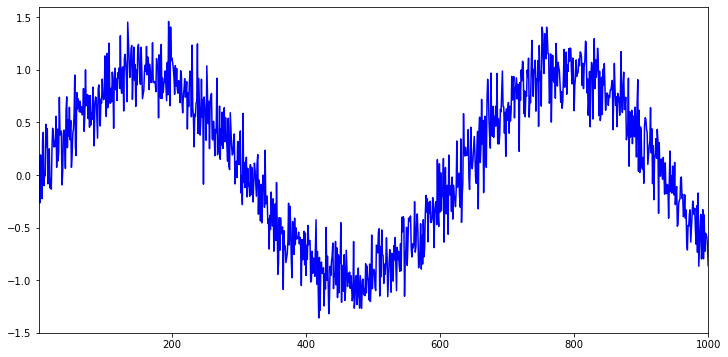

In [2]:
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.figure(figsize=(12, 6))
plt.plot(time, x, '-b')
plt.xlim(1, 1000)

In [3]:
def generate_date(tau):
    features = torch.zeros((T - tau, tau))
    for i in range(tau):
        features[:, i] = x[i: T - tau + i]
    labels = x[tau:].reshape((-1, 1))
    num_workers = 0
    batch_size, n_train = 20, 600
    train_loader = DataLoader(dataset=data.TensorDataset(features[:n_train], labels[:n_train]), 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers)
    train_iter = iter(train_loader)
    test_loader = DataLoader(dataset=data.TensorDataset(features[n_train:], labels[n_train:]), 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = iter(test_loader)
    print(len(train_loader), len(test_loader))
    print(len(train_iter), len(test_iter))
    return train_loader, test_loader, features

train_loader, test_loader, features = generate_date(tau=4)

30 20
30 20


In [4]:
datas, targets = next(iter(train_loader))
print(datas)
print(targets)

tensor([[ 0.5788,  1.0003,  0.6577,  0.7203],
        [ 0.7161,  0.7325,  1.1328,  1.0355],
        [-0.7420, -0.5478, -0.5116, -1.1520],
        [-0.8598, -1.1064, -0.7588, -1.1934],
        [-0.6650, -0.6250, -0.6245, -1.0185],
        [-0.4542, -1.2116, -0.8654, -0.8598],
        [ 0.5972,  0.6492,  0.5715,  0.5790],
        [-0.6558, -0.6945, -0.6459, -0.2545],
        [ 0.7668,  1.0405,  0.8430,  1.0137],
        [ 0.6492,  0.5715,  0.5790,  0.8219],
        [-0.6900, -0.8047, -0.7261, -0.8571],
        [-0.4898,  0.1061, -0.3529,  0.0206],
        [-0.9163, -1.0697, -1.0989, -0.6683],
        [ 0.8239,  0.8568,  0.6971,  0.4658],
        [-0.7913, -1.1577, -0.9949, -0.8312],
        [ 0.9143,  0.7082,  0.9715,  0.9220],
        [ 0.9552,  0.6973,  0.5911,  0.7495],
        [ 0.5427,  1.1430,  0.9055,  0.7301],
        [ 0.8568,  0.6971,  0.4658,  0.7213],
        [ 0.6274,  0.7241,  0.6938,  0.6000]])
tensor([[ 0.7649],
        [ 0.5558],
        [-0.6806],
        [-1.0934],
   

In [5]:
def simple_mlp():
    net = nn.Sequential(nn.Linear(4, 32),
                        nn.ReLU(),
                        nn.Linear(32, 1))
    return net

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.model = simple_mlp()
    def forward(self, x):
        x = self.model(x)
        return x

In [6]:
def train_model(model, name, epoch_num=500, device='cuda', learning_rate=0.01, train_loader=train_loader, test_loader=test_loader):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)
    if device == 'cuda':
        print("Use CUDA for training.")
        model = torch.nn.DataParallel(model) # make parallel
        cudnn.benchmark = True
    
    model.to(device)
    # specify loss function
    criterion = nn.MSELoss(reduction='none')
    # specify optimizer
    optimizer = optim.Adam(model.parameters(), learning_rate)
    train_losslist = []
    valid_losslist = []

    for epoch in range(1, epoch_num+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.sum().backward()
            optimizer.step()
            train_loss += loss.sum().item()*data.size(0)

        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.sum().item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        train_losslist.append(train_loss)
        valid_losslist.append(valid_loss)
        print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t valid_loss ->", valid_loss)
    
    os.mkdir("./result/") if os.path.exists("./result/") == False else print("./result/ exists.")
    torch.save(model.state_dict(), './result/' + name + '.pt')
    return train_losslist, valid_losslist, model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_losslist, valid_losslist, model = train_model(SimpleMLP(), "reg_sin_simplemlp", 
                                                    10, device, learning_rate=0.05)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 1.8120707591374716 			 valid_loss -> 1.3878563672605186
Epoch -> 2 	 train_loss -> 1.2825097580750784 			 valid_loss -> 1.14672200607531
Epoch -> 3 	 train_loss -> 1.1322562257448832 			 valid_loss -> 1.2120970903020916
Epoch -> 4 	 train_loss -> 1.2414306700229645 			 valid_loss -> 1.1059022618062568
Epoch -> 5 	 train_loss -> 1.045148554444313 			 valid_loss -> 1.2447457545333438
Epoch -> 6 	 train_loss -> 1.0937581380208334 			 valid_loss -> 1.1162706577416621
Epoch -> 7 	 train_loss -> 1.1005321343739827 			 valid_loss -> 1.3924353345476015
Epoch -> 8 	 train_loss -> 1.0449253578980764 			 valid_loss -> 1.0926146254394993
Epoch -> 9 	 train_loss -> 1.0992740194002788 			 valid_loss -> 1.1177267414150815
Epoch -> 10 	 train_loss -> 1.0988428254922231 			 valid_loss -> 1.304557750923465
./result/ exists.


In [8]:
def plot_losses(train_losslist, valid_losslist):
    plt.plot(train_losslist, '-bx')
    plt.plot(valid_losslist, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

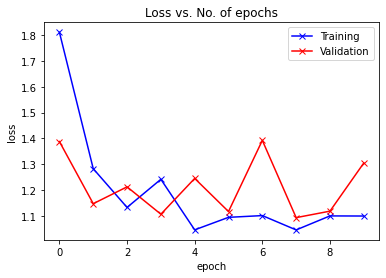

In [9]:
plot_losses(train_losslist, valid_losslist)

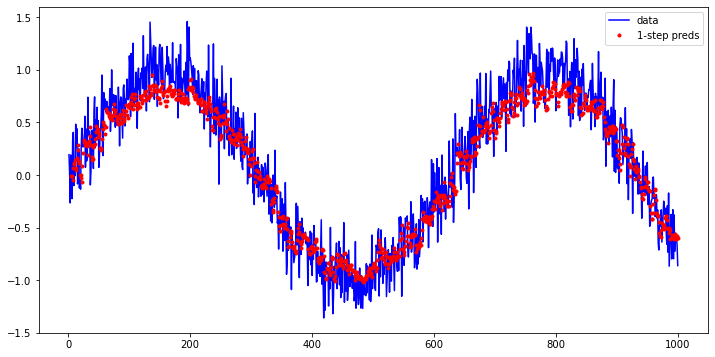

In [10]:
tau, n_train = 4, 600
onestep_preds = model(features)
plt.figure(figsize=(12, 6))
plt.plot(time, x.detach().numpy(), '-b')
plt.plot(time[tau:], onestep_preds.cpu().detach().numpy(), '.r')
plt.legend(['data', '1-step preds'])

- The one-step-ahead predictions look nice, just as we expected. Even beyond `604 (n_train + tau)` observations the predictions still look trustworthy. However, there is just one little problem to this: if we observe sequence data only until time step 604, we cannot hope to receive the inputs for all the future one-step-ahead predictions. Instead, we need to work our way forward one step at a time:

$$
\begin{split}\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots\end{split}
$$


In [11]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = model(multistep_preds[i - tau:i].reshape((1, -1)))

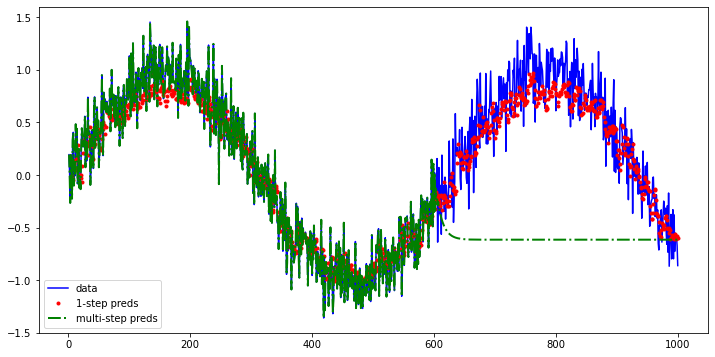

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(time, x.detach().numpy(), '-b')
plt.plot(time[tau:], onestep_preds.cpu().detach().numpy(), '.r')
plt.plot(time, multistep_preds.cpu().detach().numpy(), '-.g', linewidth=2)
plt.legend(['data', '1-step preds', 'multi-step preds'])
# plt.ylim(-4, 2)

- Let us take a closer look at the difficulties in -step-ahead predictions by computing predictions on the entire sequence for $k=1, 4, 16, 64$.

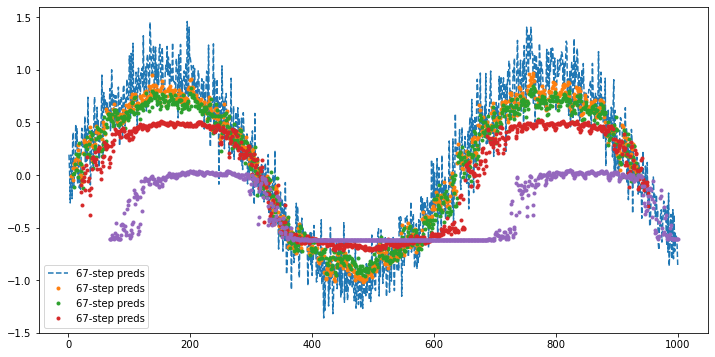

In [13]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = model(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
plt.figure(figsize=(12, 6))
plt.plot(time, x.detach().numpy(), '--')
for step in steps:
    plt.plot(time[tau + step - 1: T - max_steps + step], features[:, (tau + step - 1)].cpu().detach().numpy(), '.')
plt.legend([str(i) + '-step preds' for step in steps])

# Text Preprocessing

- Load text as strings into memory.
- Split strings into tokens (e.g., words and characters).
- Build a table of vocabulary to map the split tokens to numerical indices.
- Convert text into sequences of numerical indices so they can be manipulated by models easily.


In [15]:
def download(url, sha1_hash, cache_dir=os.path.join('.', 'data')):
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [22]:
txt_file = download('http://d2l-data.s3-accelerate.amazonaws.com/' + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine():  #@save
    """Load the time machine dataset into a list of text lines."""
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print("text lines ->", len(lines))
print(lines[0])
print(lines[10])

text lines -> 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


### Tokenization

- The following tokenize function takes a list (lines) as the input, where each element is a text sequence (e.g., a text line). Each text sequence is split into a list of tokens. A token is the basic unit in text. In the end, a list of token lists are returned, where each token is a string.

In [23]:
def tokenize(lines, token='word'):  #@save
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


### Vocabulary

- The string type of the token is inconvenient to be used by models, which take numerical inputs. Now let us build a dictionary, often called vocabulary as well, to map string tokens into numerical indices starting from 0. To do so, we first count the unique tokens in all the documents from the training set, namely a corpus, and then assign a numerical index to each unique token according to its frequency. Rarely appeared tokens are often removed to reduce the complexity. Any token that does not exist in the corpus or has been removed is mapped into a special unknown token "\<unk>". We optionally add a list of reserved tokens, such as "\<pad>" for padding, "\<bos>" to present the beginning for a sequence, and "\<eos>" for the end of a sequence.

In [24]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):  #@save
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [28]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


def load_corpus_time_machine(max_tokens=-1):  #@save
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

# Language Models